In [1]:
# Install required libraries
!pip install librosa tensorflow scikit-learn
!pip install sounddevice numpy librosa tensorflow

In [2]:
!pip install pipwin
!pipwin install pyaudio

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
  Created wheel for pipwin: filename=pipwin-0.5.2-py2.py3-none-any.whl size=8769 sha256=c7645d962dc6b37b5bbfd9402e61f5c2eb5c6b7b64a76d591091bac81617545b
  Stored in directory: /root/.cache/pip/wheels/b4/2c/53/c5a91c548b9f030b592608c24efda23ff966b1cceac6414765
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25984 sha256=6255f8619e0517bfa5a1b4289f567e733ee807dec476b27de68fe52a87afb6f0
  Stored in directory: /root/.cache/pip/wheels/5e/81/26/5956478df303e2bf5a85a5df595bb307bd25948a4bab69f7c7
Successfully built pipwin pyjsparser
/opt/conda/lib/python3.10/site-packages/pipwin/command.py:66: UserWarning: Found a non Windows system. Package installation might not work.
  warn("Found a non Windows system. Package installation might not work.")
Building cache. Hang on . . .
Traceback (most recent cal

In [3]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import random
import soundfile as sf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import librosa.display
import matplotlib.pyplot as plt
import time
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import librosa.display
import matplotlib.pyplot as plt
import time

In [4]:
# Define the main path for the dataset
Main_WAV_Path = Path("../input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data")

In [5]:
# Adjusted extract_mfcc_features to handle both file paths and raw waveform data
def extract_mfcc_features(audio_path_or_waveform, sr=None, max_pad_len=500):
    if isinstance(audio_path_or_waveform, str):  # If input is a file path
        y, sr = librosa.load(audio_path_or_waveform, sr=sr)
    else:  # If input is a raw waveform
        y = audio_path_or_waveform
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # Increased MFCCs for richer features
    
    # Padding to ensure consistent input size
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    return mfccs.T

In [6]:
# Data Augmentation Methods (Noise, Shift, Stretch)
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    y_noise = y + noise_factor * noise
    y_noise = np.clip(y_noise, -1.0, 1.0)
    return y_noise

def time_shift(y, shift_max=2):
    shift = random.randint(-shift_max, shift_max)
    return np.roll(y, shift)

def time_stretch(y, rate=1.1):
    return librosa.effects.time_stretch(y, rate=1.1)

In [7]:
# Load data function (corrected)
def load_data(dataset_path, labels_mapping, augment=False):
    features = []
    labels = []
    
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for file in os.listdir(label_path):
            if file.endswith(".wav"):  # Assuming audio files are in WAV format
                file_path = os.path.join(label_path, file)
                
                # Extract MFCC features from the original audio
                y, sr = librosa.load(file_path, sr=None)
                mfcc_features = extract_mfcc_features(y, sr=sr)
                features.append(mfcc_features)  # Add original features
                labels.append(label)
                
                if augment:
                    # Data Augmentation
                    features.append(extract_mfcc_features(add_noise(y), sr=sr))  # Noise-added
                    features.append(extract_mfcc_features(time_shift(y), sr=sr))  # Time-shifted
                    features.append(extract_mfcc_features(time_stretch(y, rate=1.1), sr=sr))  # Time-stretched
                    labels.extend([label] * 3)  # Same label for augmented samples
    
    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    # Pad or truncate features to have consistent shape
    max_length = max([x.shape[0] for x in features])
    features = [np.pad(x, ((0, max_length - x.shape[0]), (0, 0)), mode='constant') for x in features]
    
    return np.array(features), to_categorical(np.array(labels)), label_encoder

# Load data with corrected functions
emotions = os.listdir(Main_WAV_Path)
X, y, label_encoder = load_data(Main_WAV_Path, labels_mapping=emotions, augment=True)

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Reshape data for LSTM input (LSTM expects 3D input: samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [10]:
# Build the RNN model
model = Sequential()

# Add LSTM layers
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

# Output layer (softmax for multi-class classification)
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.0730 - loss: 2.6749 - val_accuracy: 0.0701 - val_loss: 2.6427
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.0730 - loss: 2.6463 - val_accuracy: 0.0429 - val_loss: 2.7226
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.0707 - loss: 2.6408 - val_accuracy: 0.0670 - val_loss: 2.6401
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.0733 - loss: 2.6398 - val_accuracy: 0.0714 - val_loss: 2.6415
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.0738 - loss: 2.6366 - val_accuracy: 0.0790 - val_loss: 2.8537
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.2469 - loss: 1.8584 - val_accuracy: 0.0728 - val_loss: 3.2763
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.3628 - loss: 1.3519 - val_accuracy: 0.1388 - val_loss: 4.2778
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.5680 -

In [11]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


In [12]:
# Calculate performance metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

In [13]:
# Print results
max_val_accuracy = max(history.history['val_accuracy'])
print(f"Accuracy: {avg_val_accuracy:.4f}")
print(f"Max Validation Accuracy: {max_val_accuracy:.4f}")
avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.8960
Max Validation Accuracy: 0.9987
Precision: 0.9982
Recall: 0.9982
F1 Score: 0.9982


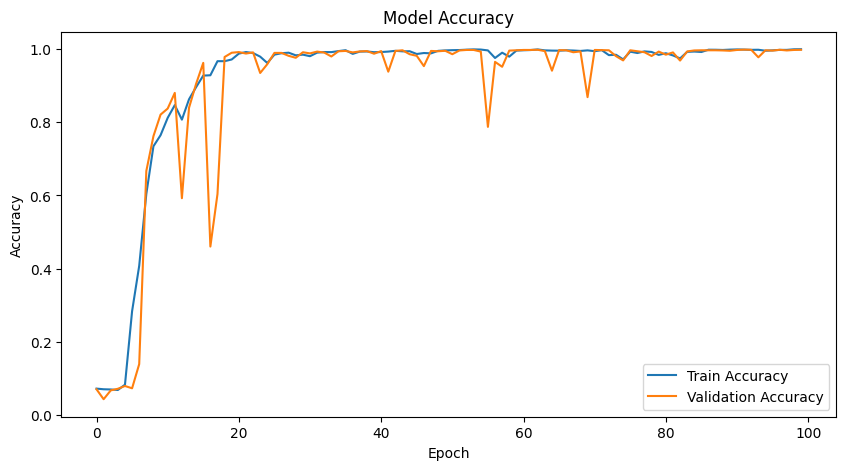

In [14]:
# Optional: Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

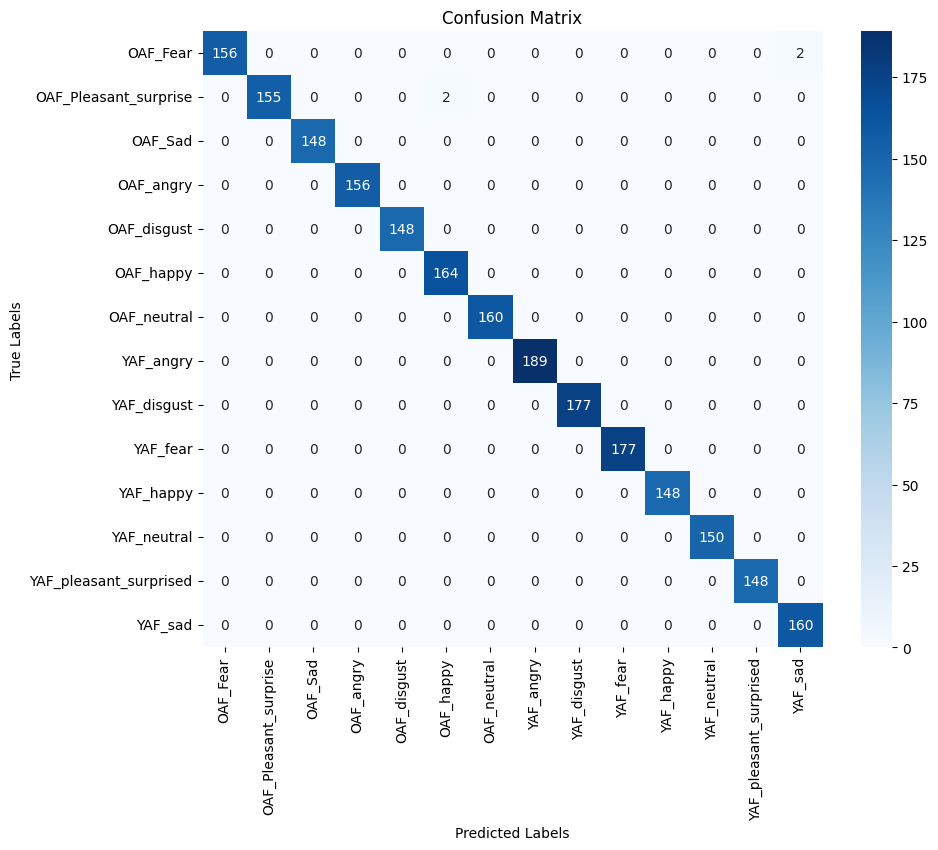

In [15]:
# Predict classes for the test set
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [16]:
print(f"Accuracy: {avg_val_accuracy:.4f}")

Accuracy: 0.8960


In [17]:
# Load the saved model if needed (ensure model is saved first)
# model = load_model('your_model.h5')  # Uncomment if needed

# Define a function to predict emotion from a given audio file
def predict_emotion_from_file(file_path):
    # Load the audio file and extract MFCC features
    audio, sr = librosa.load(file_path, sr=None)
    mfcc_features = extract_mfcc_features(audio, sr)
    
    # Reshape features for the model input
    mfcc_features = np.reshape(mfcc_features, (1, mfcc_features.shape[0], mfcc_features.shape[1]))
    
    # Predict the emotion
    prediction = model.predict(mfcc_features)
    predicted_class = np.argmax(prediction, axis=1)
    
    # Map predicted class to emotion
    predicted_emotion = label_encoder.inverse_transform(predicted_class)
    
    # Print the predicted emotion
    print(f"Predicted Emotion for {file_path}: {predicted_emotion[0]}")

# Example usage: Predict the emotion for 5 audio files
audio_files = [
    '/kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav',
    '/kaggle/input/cremad/AudioWAV/1001_DFA_FEA_XX.wav',
    '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav',
    '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad.wav',
    '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_back_ps.wav'
]

for file in audio_files:
    predict_emotion_from_file(file)
    

files_to_predict = [
    '/kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav',
    '/kaggle/input/cremad/AudioWAV/1001_DFA_FEA_XX.wav',
    '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav',
    '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad.wav',
    '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_back_ps.wav'
]

# Loop over the files and predict emotion for each
for file in files_to_predict:
    predict_emotion_from_file(file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Predicted Emotion for /kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav: YAF_disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Emotion for /kaggle/input/cremad/AudioWAV/1001_DFA_FEA_XX.wav: YAF_disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Emotion for /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav: OAF_Fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Emotion for /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad.wav: OAF_Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Emotion for /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_back_ps.wav: OAF_Pleasant_surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Emotion for /kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav: YAF_disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Emotion f